# Web Scrapping Github Repositories
In order to grasp a comprehensive scope of current status of all repositories under our lab, I built this brief web scraper to organize my workflow. The motivation for search selection is based on the need of each repo. To gauge the level of needs, I chose to parse out `the number of issues`. Additionally, `last updated dates` are also important to understand whether the repo is actively managed at this time.

## Import packages

In [1]:
import urllib.request
import re
import pandas as pd
pd.options.display.max_rows = None
import matplotlib.pyplot as plt
import seaborn as sns

## Manually set the total number of repos under the organization

In [2]:
repo_count = 236 #number of repos

## Request url of each pages
Imported pages are `read()` as html after which it is decoded as a utf-8 format

In [3]:
total_page = 236//30 + 1 if 4%5 > 0 else 0
data = []
for i in range(1, total_page+1):
    tmp = urllib.request.urlopen(f'https://github.com/orgs/neurodata/repositories?page={i}')
    data.append(tmp.read().decode('utf-8'))
    print(tmp.url)

https://github.com/orgs/neurodata/repositories?page=1
https://github.com/orgs/neurodata/repositories?page=2
https://github.com/orgs/neurodata/repositories?page=3
https://github.com/orgs/neurodata/repositories?page=4
https://github.com/orgs/neurodata/repositories?page=5
https://github.com/orgs/neurodata/repositories?page=6
https://github.com/orgs/neurodata/repositories?page=7
https://github.com/orgs/neurodata/repositories?page=8


In [4]:
data[0][:1000]

'\n\n<!DOCTYPE html>\n<html lang="en" data-color-mode="auto" data-light-theme="light" data-dark-theme="dark">\n  <head>\n    <meta charset="utf-8">\n  <link rel="dns-prefetch" href="https://github.githubassets.com">\n  <link rel="dns-prefetch" href="https://avatars.githubusercontent.com">\n  <link rel="dns-prefetch" href="https://github-cloud.s3.amazonaws.com">\n  <link rel="dns-prefetch" href="https://user-images.githubusercontent.com/">\n  <link rel="preconnect" href="https://github.githubassets.com" crossorigin>\n  <link rel="preconnect" href="https://avatars.githubusercontent.com">\n\n\n\n  <link crossorigin="anonymous" media="all" integrity="sha512-1G4rYJktwRTQKn7fVfJUxH8RRZFUJlGo77xMZfBfIhZPx4BHVrzPE1VgnafttXI8G3y/PywH3uXyhNkSLp3+oA==" rel="stylesheet" href="https://github.githubassets.com/assets/light-d46e2b60992dc114d02a7edf55f254c4.css" /><link crossorigin="anonymous" media="all" integrity="sha512-hI5b2oqTE9njfjYrfuzXqA4bSGSNrE5OMc9IiFhZy+RDGg9Qn4Si1A97o0MlinlwFt3xAifvoLX0s7jH

## Main body of the scraper

In [5]:
dat = []
rl = 500 #read length

for d in data:
    exist = True

    while exist:
        exist = re.search('/neurodata/.*/issues', d)

        if not exist:
            break

        idx = re.search('href="/neurodata/.*/issues', d).span()
        key = d[idx[0]:idx[1]]
        tmp = d[idx[0]:idx[0]+rl]
        word = '\n</a>\n'
        tmp_loc = tmp.find(word)
        tmp_dat = [re.split('/', key)[2], (int(tmp[tmp_loc-3:tmp_loc]))]

        tmp = d[idx[0]:idx[0]+rl*10]
        word = '<relative-time datetime="'
        tmp_loc = tmp.find(word)
        l = tmp_loc+len(word)
        tmp_dat.append(tmp[l:l+10])
        dat.append(tmp_dat)

        d = d[idx[0]+rl:]

## Checking to make sure we've collected all repos

In [6]:
len(dat), dat[:30]

(236,
 [['talks', 1, '2021-12-09'],
  ['hyppo', 31, '2021-12-09'],
  ['ProgLearn', 43, '2021-12-09'],
  ['brainlit', 72, '2021-12-08'],
  ['ood-workshop', 0, '2021-12-08'],
  ['SDTF', 9, '2021-12-08'],
  ['neurodata.io', 4, '2021-12-08'],
  ['graph-stats-book', 17, '2021-12-07'],
  ['graphbook-code', 2, '2021-12-07'],
  ['scikit-learn', 5, '2021-12-07'],
  ['SPORF', 90, '2021-12-05'],
  ['kdg', 9, '2021-12-05'],
  ['bilateral-connectome', 8, '2021-12-03'],
  ['m2g', 28, '2021-12-02'],
  ['nd_ed', 2, '2021-12-02'],
  ['double_descent', 0, '2021-12-01'],
  ['MCC', 3, '2021-11-28'],
  ['hierarchical', 0, '2021-11-22'],
  ['maggot_models', 33, '2021-11-17'],
  ['latex-template', 0, '2021-11-17'],
  ['df-dn-paper', 12, '2021-11-15'],
  ['goat', 0, '2021-11-12'],
  ['scipy', 0, '2021-11-10'],
  ['combining-representations', 0, '2021-11-01'],
  ['task-similarity', 2, '2021-10-22'],
  ['notebooks', 1, '2021-09-28'],
  ['CloudReg', 1, '2021-09-17'],
  ['improving-latent-distribution-test', 0, '

## Save nested lists as a tabulated form for data wrangling

In [7]:
df = pd.DataFrame(data=dat, columns=['Repository', 'Issues', 'Last Update'])
df.head(20)

,Repository,Issues,Last Update
0,talks,1,2021-12-09
1,hyppo,31,2021-12-09
2,ProgLearn,43,2021-12-09
3,brainlit,72,2021-12-08
4,ood-workshop,0,2021-12-08
5,SDTF,9,2021-12-08
6,neurodata.io,4,2021-12-08
7,graph-stats-book,17,2021-12-07
8,graphbook-code,2,2021-12-07
9,scikit-learn,5,2021-12-07


## Change dtype of date as datetime

In [8]:
df['Last Update'] = pd.to_datetime(df['Last Update'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Repository   236 non-null    object        
 1   Issues       236 non-null    int64         
 2   Last Update  236 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 5.7+ KB


## Visualization of the first 30 repos

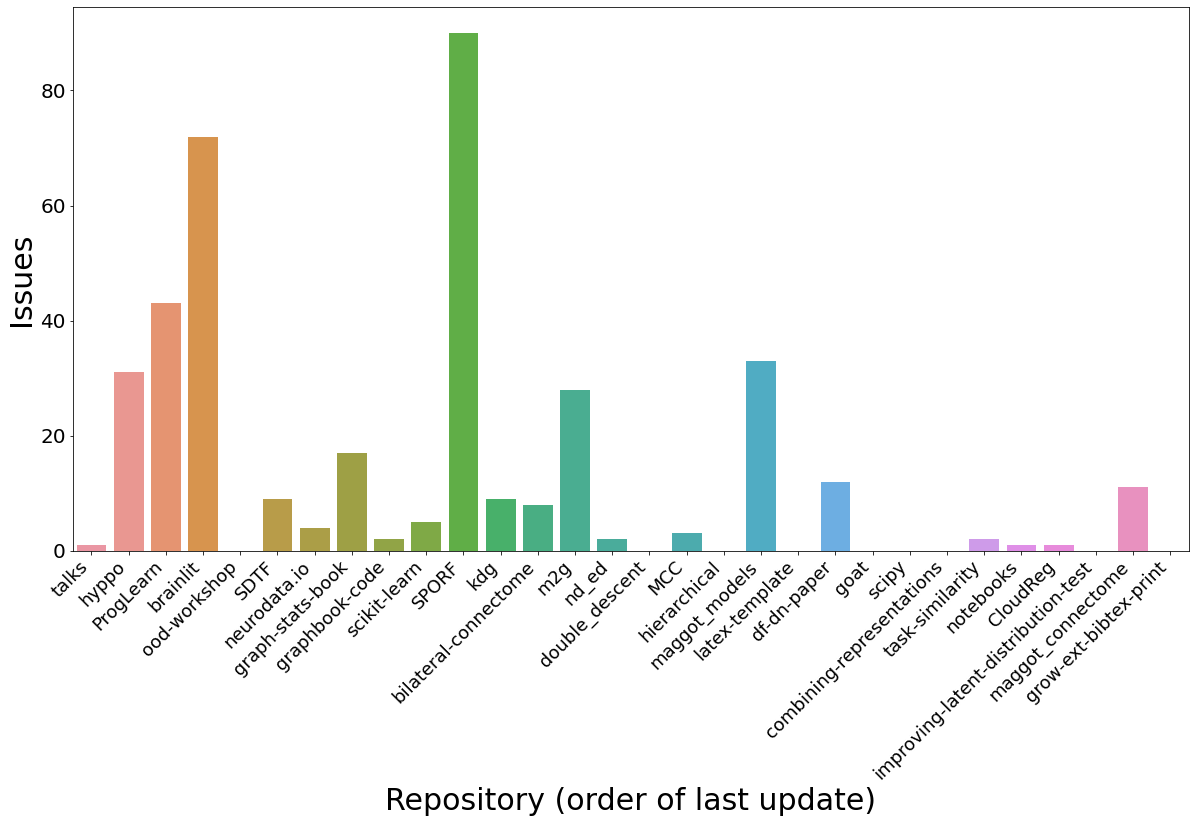

In [9]:
xlabel = 'Repository'
ylabel = 'Issues'

fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.barplot(data=df.head(30), x=xlabel, y=ylabel, ax=ax)
ax.set_xticklabels(labels=df['Repository'][:30], rotation=45, ha='right', fontsize=18);
ax.set_xlabel(xlabel=xlabel+' (order of last update)', fontsize=30);
ax.set_ylabel(ylabel=ylabel, fontsize=30);
plt.yticks(fontsize=20);
plt.savefig('./fig/output-b4-filtering.jpg', bbox_inches='tight')

## Filter data
1. Nubmer of Issues > 0
2. Last Updated Date is no earlier than `2021-09-01`

In [10]:
sorted_df = df.sort_values(by='Issues', ascending=False)
sorted_df = sorted_df.sort_values(by='Last Update', ascending=False)
sorted_df = sorted_df.query('Issues > 0')
sorted_df = sorted_df[sorted_df['Last Update'] > '2021-09-01']
sorted_df.head(20)

,Repository,Issues,Last Update
2,ProgLearn,43,2021-12-09
0,talks,1,2021-12-09
1,hyppo,31,2021-12-09
5,SDTF,9,2021-12-08
3,brainlit,72,2021-12-08
6,neurodata.io,4,2021-12-08
7,graph-stats-book,17,2021-12-07
8,graphbook-code,2,2021-12-07
9,scikit-learn,5,2021-12-07
10,SPORF,90,2021-12-05


## Visualization after filtering

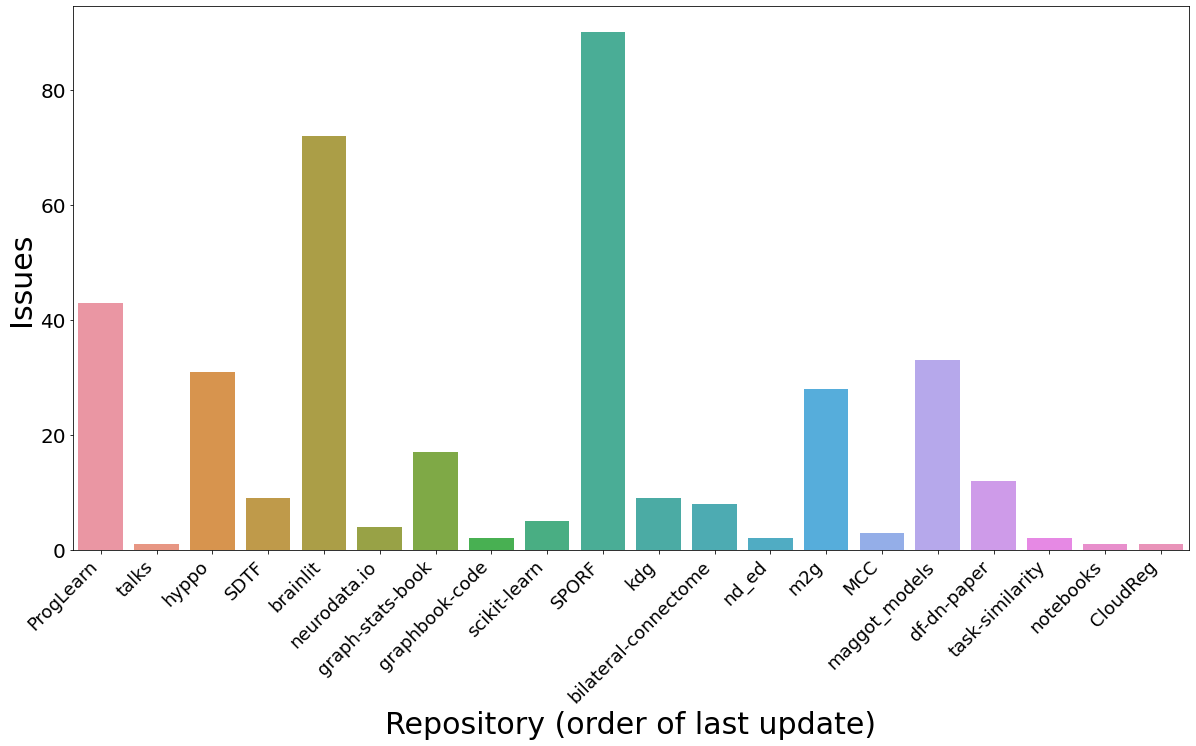

In [12]:
xlabel = 'Repository'
ylabel = 'Issues'

fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.barplot(data=sorted_df, x=xlabel, y=ylabel, ax=ax)
ax.set_xticklabels(labels=sorted_df['Repository'], rotation=45, ha='right', fontsize=18);
ax.set_xlabel(xlabel=xlabel+' (order of last update)', fontsize=30);
ax.set_ylabel(ylabel=ylabel, fontsize=30);
plt.yticks(fontsize=20);
plt.savefig('./fig/output.jpg', bbox_inches='tight')